In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
np.set_printoptions(threshold=np.inf)

# Basaltic dike in country rocks

In [3]:
# Globals
T0 = 300 #uR
T1 = 1200 #uL
alpha = 10**(-6)
W = 5
L = 100
N = 100
dx = L/(2*N) #step - 1/N multipied by length in one direction
dt = 3600*24 #day
l = (alpha*dt)/dx**2 #lambda

In [18]:
def T(x): 
    """Fill initial values of Temperature at time 0 in all positions"""
    starting_u = np.zeros(x.size)
    for i in range(len(x)):
        if abs(x[i])<(W/2): 
            starting_u[i] = T1
        else: starting_u[i] = T0
    return starting_u

In [19]:
x = np.arange(-L/2, L/2, dx)
t_max = dt*10**5 #seconds
t = np.arange(0, t_max, dt) #vector of time
u = np.zeros(shape=(t.size, x.size)) # matrix for results
        
u[0] = T(x)
middle_point = int(x.size/2)

In [19]:
# Prepare tridiagonal matrix A from the lecture (here marked as M)
A = np.zeros(x.size)
B = np.zeros(x.size)
C = np.zeros(x.size)

A.fill(l)
B.fill(1-2*l)
C.fill(l)
B[0]=B[-1]=1
C[0]=0
A[-2]=0

diagonals = [B,A,C]
a = B.shape[0]
M = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray()

Calculcate $t_f$ needed for the dike to cool down to a temperature $\Delta T=10^{\circ}C$ higher then $T_0$

In [44]:
i=0
while not u[i+1][middle_point] < T0+10:
    u[i+1] = M.dot(u[i])
    i+=1
        
print(u[i][middle_point])
tf = i
print(f't_f = {t[tf]} seconds')

310.0007374045833
t_f = 2102371200 seconds


Plot the temperature distributions $T(x,t_i)$ for times $t_1=0.1t_f, t_2=0.25t_f, t_3=0.5t_f$ and $t_4=0.75t_f$

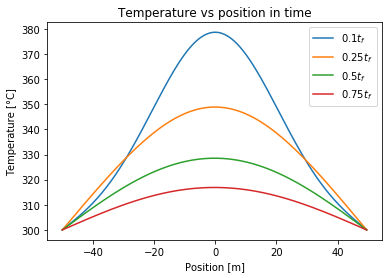

In [45]:
plt.plot(x, u[int(tf*0.1)], label='$0.1t_f$')
plt.plot(x, u[int(tf*0.25)], label='$0.25t_f$')
plt.plot(x, u[int(tf*0.5)], label='$0.5t_f$')
plt.plot(x, u[int(tf*0.75)], label='$0.75t_f$')
plt.legend()
plt.xlabel("Position [m]");
plt.ylabel("Temperature [°C]");
plt.title("Temperature vs position in time");
plt.show()

Record and plot the temperature evolution versus time at a distance of $5$ m from the dike--country rock contact. What is the maximum temperature the country rock experiences at this location and when is it reached?

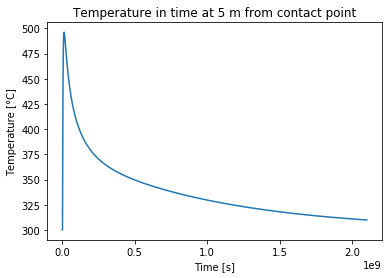

Maximal measure temperature is 496.25966118000633


In [64]:
distance = int(5/dx)+middle_point # 5m to the right from dike-rock contact

contact = np.zeros(tf)
for i in range(tf):
    contact[i] = u[i][distance]
    
plt.plot(t[:contact.size], contact)
plt.ylabel("Temperature [°C]")
plt.xlabel("Time [s]")
plt.title("Temperature in time at 5 m from contact point")
plt.show()
print(f'Maximal measure temperature is {contact.max()}')

# Crank-Nicolson

I am using substitution $r=\alpha \frac{\Delta t}{\Delta x^2}$ in this solution. With that, we can write the Crank-Nicholson scheme as $Au_{j+1} = Bu_j + b$, which after rearanging gives 
$$ u_{j+1} = A^{−1} Bu_{j} + A^{−1}b_j $$
where 
$$
A = \begin{bmatrix}
2+2r & -r & 0 & \dots & 0 & 0 \\
-r & 2+2r & -r & 0 & \dots & 0 \\
\dots & \dots & \dots & \dots & \dots & \dots  \\
0 & \dots & 0 & -r & 2+2r & -r \\
0 & \dots & 0 & 0 &-r & 2+2r
\end{bmatrix}
$$
and 
$$
B = \begin{bmatrix}
2-2r & r & 0 & \dots & 0 & 0 \\
r & 2-2r & r & 0 & \dots & 0 \\
\dots & \dots & \dots & \dots & \dots & \dots  \\
0 & \dots & 0 & r & 2-2r & r \\
0 & \dots & 0 & 0 & r & 2-2r
\end{bmatrix}
$$

In [128]:
# Globals
N = 51
dx = 1/(N-1)
dt = 0.0005
t_max = 0.1
number_of_time_steps = int(t_max/dt) + 1
number_of_plots = 5
alpha = 1
r = alpha * dt/dx**2

In [129]:
# Prepare tridiagonal matrices A and B
a = np.zeros(N-2)
b = np.zeros(N-2)
c = np.zeros(N-2)

a.fill(-r)
b.fill(2+2*r)
c.fill(-r)
diagonals = [b,a,c]
sh = b.shape[0]
A = sparse.diags(diagonals, [0,-1,1], shape=(sh,sh)).toarray()

a.fill(r)
b.fill(2-2*r)
c.fill(r)
diagonals = [b,a,c]
sh = b.shape[0]
B = sparse.diags(diagonals, [0,-1,1], shape=(sh,sh)).toarray()

In [130]:
b = np.zeros(N-2)
x = np.linspace(0,1,N) #grid
u = np.sin(np.pi*x) + np.sin(3*np.pi*x) #initial condition
bb = B.dot(u[1:-1]) + b # u[1:-1] - dirty little trick to have zeros 

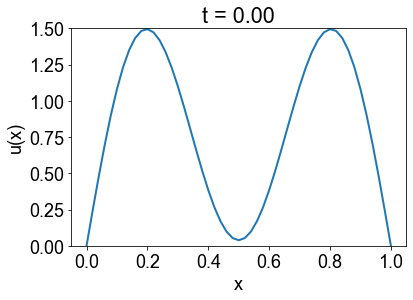

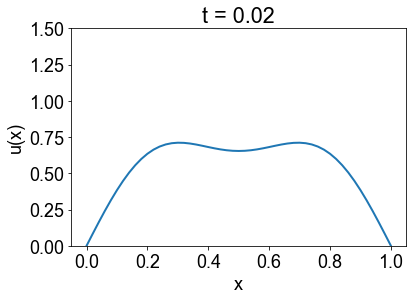

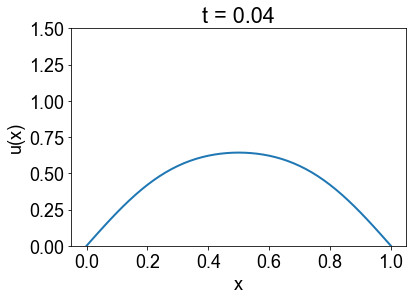

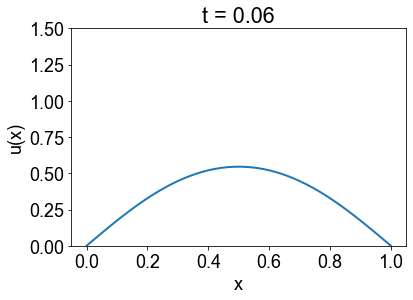

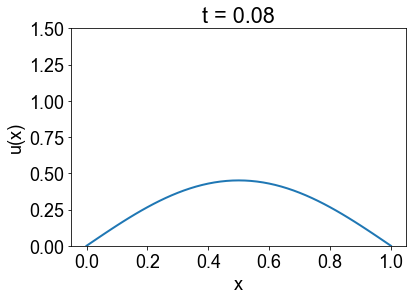

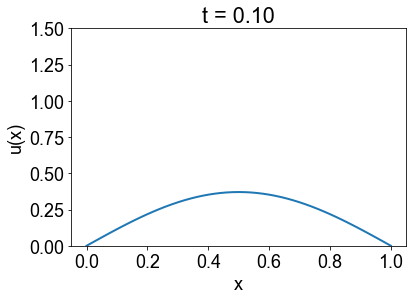

In [131]:
result = np.zeros(shape=(number_of_time_steps, N))
c = 0
for j in range(number_of_time_steps):
    u[1:-1] = np.linalg.solve(A,bb)
    bb = B.dot(u[1:-1]) + b
    result[j] = u
    if(j%int(number_of_time_steps/number_of_plots)==0): 
        plt.plot(x,u,linewidth=2)
        plt.ylim([0,1.5])
        plt.xlabel("x")
        plt.ylabel("u(x)")
        plt.title("t = %2.2f"%(dt*(j+1)))
        plt.show()
        c += 1

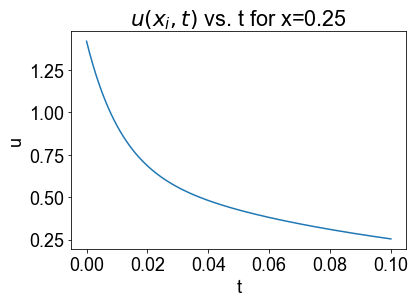

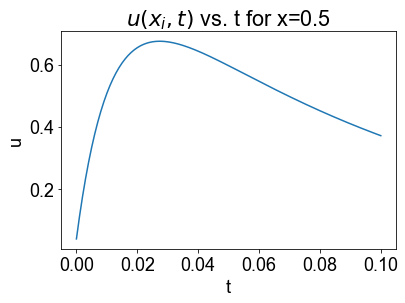

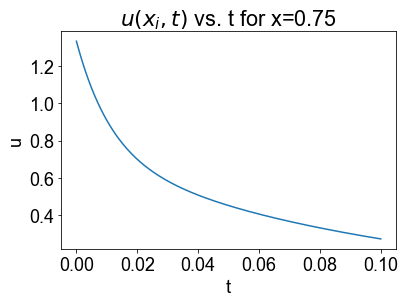

In [148]:
# Ok. I know this is horrible code. But it does what it should and I am too tired to think of a "prettier" solution
t_025 = int(N/4)
t_05 = int(N/2)
t_075 = t_025 + t_05
x_025 = []
x_05 = []
x_075 = []
for i in range(result.shape[0]):
    x_025.append(result[i][t_025])
    x_05.append(result[i][t_05])
    x_075.append(result[i][t_075])

t = np.arange(0, t_max+dt, dt)
plt.plot(t, x_025)
plt.title(r'$u(x_i,t)$ vs. t for x=0.25')
plt.xlabel('t')
plt.ylabel('u')
plt.show()

plt.plot(t, x_05)
plt.title(r'$u(x_i,t)$ vs. t for x=0.5')
plt.xlabel('t')
plt.ylabel('u')
plt.show()

plt.plot(t, x_075)
plt.title(r'$u(x_i,t)$ vs. t for x=0.75')
plt.xlabel('t')
plt.ylabel('u')
plt.show()